<a href="https://colab.research.google.com/github/Akash8292/Natural_Sound_Recognition/blob/main/Natural_Sound_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import wave
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import librosa
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import os
from tensorflow.keras.utils import to_categorical



In [ ]:
  # !pip install np_utils

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
wav_obj = wave.open('/content/drive/MyDrive/UrbanSound8K/audio/fold7/101848-9-0-0.wav', 'r')


In [ ]:
sample_freq = wav_obj.getframerate()
print(sample_freq)

44100


In [ ]:
n_samples = wav_obj.getnframes()
print(n_samples)

176400


In [ ]:
time_steps = n_samples/sample_freq
print(time_steps, "seconds")

4.0 seconds


In [ ]:
audio_file = '/content/drive/MyDrive/UrbanSound8K/audio/fold7/101848-9-0-0.wav'
signal, sample_rate = librosa.load(audio_file)
print(signal)

[ 0.04671543  0.0810446   0.08158674 ... -0.00463078 -0.0046187
 -0.0049835 ]


In [ ]:
mfccs = librosa.feature.mfcc(y=signal, sr=sample_rate)

# 'mfccs' is a 2D numpy array where each column is a set of MFCCs for a frame of audio
print(mfccs.shape)

(20, 173)


In [ ]:
feature_dimension = mfccs.shape[0]
print('Feature dimension:', feature_dimension)

Feature dimension: 20


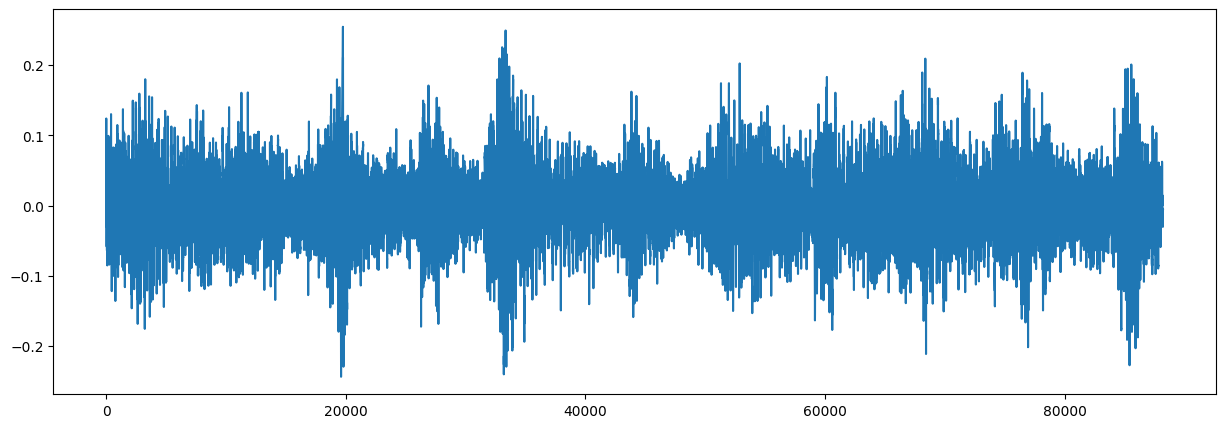

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(signal)

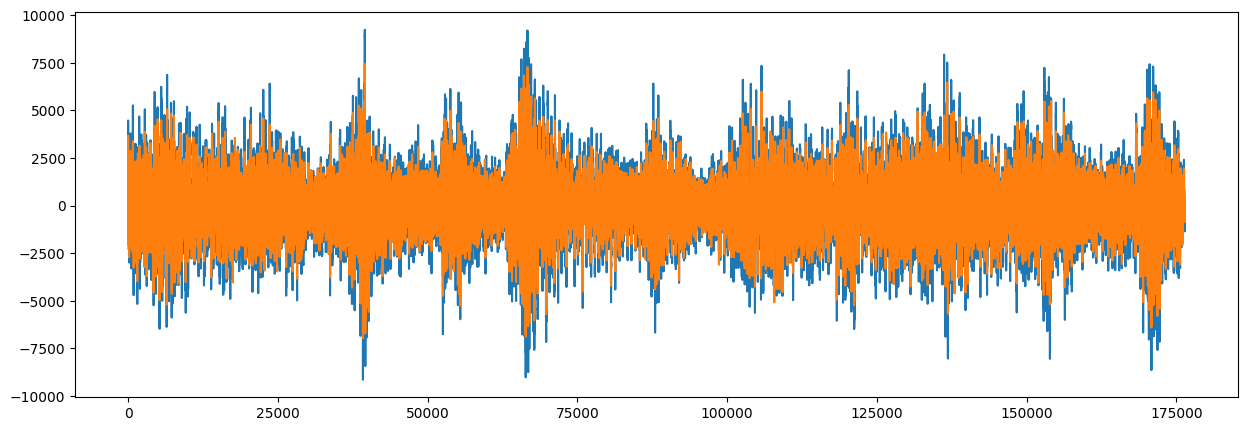

In [ ]:
from scipy.io import wavfile as wav
wave_sample_rate, wave_audio = wav.read(audio_file)

plt.figure(figsize=(15, 5))
plt.plot(wave_audio)

In [ ]:
import os
import wave

import pylab
def graph_spectrogram(wav_file):
    sound_info, frame_rate = get_wav_info(wav_file)
    pylab.figure(num=None, figsize=(12, 5))
    pylab.subplot(111)
    pylab.title('spectrogram of %r' % wav_file)
    pylab.specgram(sound_info, Fs=frame_rate)
    pylab.savefig('spectrogram.png')
def get_wav_info(wav_file):
    wav = wave.open(wav_file, 'r')
    frames = wav.readframes(-1)
    sound_info = pylab.fromstring(frames, 'int16')
    frame_rate = wav.getframerate()
    wav.close()
    return sound_info, frame_rate

<ipython-input-76-3edb9917e679>:15: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  sound_info = pylab.fromstring(frames, 'int16')


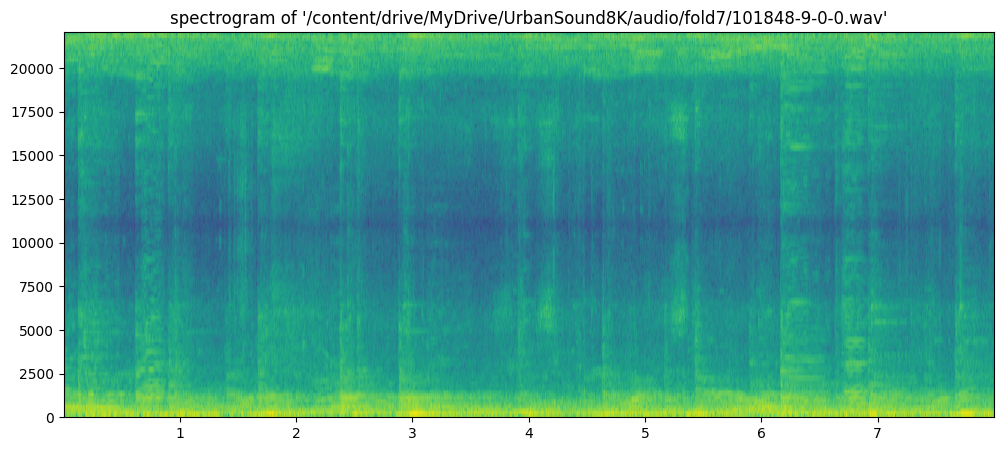

In [ ]:
 graph_spectrogram(audio_file)

In [ ]:
audio_dataset_path='/content/drive/MyDrive/UrbanSound8K/audio'
metadata=pd.read_csv('/content/drive/MyDrive/UrbanSound8K/metadata/UrbanSound8K.csv')
metadata.head()


,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [ ]:
metadata.tail()

,slice_file_name,fsID,start,end,salience,fold,classID,class
8727,99812-1-2-0.wav,99812,159.522205,163.522205,2,7,1,car_horn
8728,99812-1-3-0.wav,99812,181.142431,183.284976,2,7,1,car_horn
8729,99812-1-4-0.wav,99812,242.691902,246.197885,2,7,1,car_horn
8730,99812-1-5-0.wav,99812,253.209850,255.741948,2,7,1,car_horn
8731,99812-1-6-0.wav,99812,332.289233,334.821332,2,7,1,car_horn


In [ ]:
def features_extractor(file):
    audio, sample_rate = librosa.load(file_name)
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate)
    new_mfcc = np.mean(mfccs_features.T,axis=0)

    return new_mfcc


In [ ]:
from tqdm import tqdm
new_features=[]
for index_num,row in tqdm(metadata.iterrows()):
    file_name = os.path.join(os.path.abspath(audio_dataset_path),'fold'+str(row["fold"])+'/',str(row["slice_file_name"]))
    class_labels=row["class"]
    extracted_data=features_extractor(file_name)
    new_features.append([extracted_data,class_labels])

3555it [26:27,  2.36it/s]/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1323
  warnings.warn(
8326it [1:01:47,  2.65it/s]/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1103
  warnings.warn(
8329it [1:01:48,  2.65it/s]/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1523
  warnings.warn(
8732it [1:04:44,  2.25it/s]


In [ ]:
new_feature_df=pd.DataFrame(new_features,columns=['feature','class'])
new_feature_df.head()

,feature,class
0,"[-211.93698, 62.58121, -122.813156, -60.745293...",dog_bark
1,"[-417.0052, 99.336624, -42.995583, 51.073326, ...",children_playing
2,"[-452.39316, 112.36253, -37.57807, 43.195866, ...",children_playing
3,"[-406.47922, 91.1966, -25.043552, 42.78452, 11...",children_playing
4,"[-439.63873, 103.86223, -42.658783, 50.690285,...",children_playing


In [ ]:
X=np.array(new_feature_df['feature'].tolist())
y=np.array(new_feature_df['class'].tolist())

In [ ]:
print(X)
print(X.shape)


[[-2.11936981e+02  6.25812111e+01 -1.22813156e+02 ... -9.43993568e-01
  -2.57990885e+00  6.09830046e+00]
 [-4.17005188e+02  9.93366241e+01 -4.29955826e+01 ...  7.03866863e+00
  -2.44226789e+00  3.47361517e+00]
 [-4.52393158e+02  1.12362534e+02 -3.75780716e+01 ...  8.22254837e-01
  -1.18684448e-01  9.37159920e+00]
 ...
 [-2.97315338e+02  1.02090256e+02 -3.67510796e+01 ...  3.60031843e+00
  -6.07771921e+00  1.09770942e+00]
 [-3.36923859e+02  1.15313904e+02 -4.48470917e+01 ...  1.92964566e+00
  -1.89814591e+00  1.15353417e+00]
 [-3.07417603e+02  8.33067245e+01 -2.57565117e+01 ...  1.50761127e+01
   4.75370502e+00  1.29508841e+00]]
(8732, 20)


In [ ]:
print(y)
print(y.shape)

['dog_bark' 'children_playing' 'children_playing' ... 'car_horn'
 'car_horn' 'car_horn']
(8732,)


In [ ]:
encoder = LabelEncoder()
encoder.fit(y)
encoded_Y = encoder.transform(y)
# convert integers to dummy variables (i.e. one hot encoded)
y = to_categorical(encoded_Y)

In [ ]:
print(y)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]


In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape the data into the format expected by the LSTM layers
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [ ]:
print(X_train)
print(X_train.shape[0])
print(X_train.shape[1])

[[[-8.2740608e+01  1.0823799e+02 -8.9479210e+01 ...  1.3142552e+01
   -4.4930100e+00  7.4209871e+00]]

 [[-1.5554037e+02  1.2451323e+02 -1.6267330e+01 ...  5.5475049e-02
   -4.5848217e+00 -5.6572092e-01]]

 [[-2.6234723e+02  1.7664906e+02 -1.1255313e+02 ...  5.2280221e+00
    1.9194070e+00 -1.5615079e+01]]

 ...

 [[-2.9107108e+02  2.3318919e+02 -4.6693287e+00 ... -4.5523901e+00
   -7.6189218e+00 -5.6469488e-01]]

 [[-1.9410327e+02  8.2565353e+01 -7.0069725e+01 ...  6.5899229e+00
    2.2905793e+00 -6.4992914e+00]]

 [[-2.6350116e+02  1.2405038e+02  2.5122182e+00 ...  2.1377572e-01
   -3.6246634e+00  1.3027918e+00]]]
6985
1


In [ ]:
print(X_test)
print(X_test.shape[0])
print(X_test.shape[1])

[[[-7.47504196e+01  1.28711075e+02 -3.17634792e+01 ... -7.72815123e-02
   -4.67133379e+00  2.01709938e+00]]

 [[-8.02253437e+00  1.12755035e+02 -1.81556683e+01 ... -2.72377110e+00
   -7.19590092e+00 -4.14205647e+00]]

 [[-1.14894302e+02  2.86524439e+00 -3.78350945e+01 ...  8.66461754e+00
   -3.01623392e+00 -3.07365918e+00]]

 ...

 [[-4.03899384e+02  1.54603958e+02  3.11124802e+01 ... -1.37136817e-01
    1.56500578e+00 -7.50729227e+00]]

 [[-1.61487656e+02  8.05604248e+01  7.75943041e+00 ... -1.24662066e+01
   -1.08117905e+01 -6.80222511e+00]]

 [[-1.90639725e+02  1.43216995e+02 -4.86565437e+01 ... -2.44940686e+00
   -6.93858576e+00  4.26243514e-01]]]
1747
1


In [ ]:
print(y_train)
print(y.shape)

[[0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 1. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]]
(8732, 10)


In [ ]:
print(y_test)
print(y_test.shape)

[[0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 1. 0.]]
(1747, 10)


In [ ]:
# KNN MULTILAYER MODEL

# Define the model
input_data = Input(shape=(X_train.shape[1], X_train.shape[2]))


lstm_layer1 = LSTM(128, return_sequences=True)(input_data)
dropout1 = Dropout(0.2)(lstm_layer1)

lstm_layer2 = LSTM(128, return_sequences=True)(dropout1)
dropout2 = Dropout(0.2)(lstm_layer2)

lstm_layer3 = LSTM(128, return_sequences=True)(dropout2)
dropout3 = Dropout(0.2)(lstm_layer3)

lstm_layer4 = LSTM(128)(dropout3)


output = Dense(10, activation='softmax')(lstm_layer4)

model = Model(inputs=input_data, outputs=output)


model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 20)]           0         
                                                                 
 lstm (LSTM)                 (None, 1, 128)            76288     
                                                                 
 dropout (Dropout)           (None, 1, 128)            0         
                                                                 
 lstm_1 (LSTM)               (None, 1, 128)            131584    
                                                                 
 dropout_1 (Dropout)         (None, 1, 128)            0         
                                                                 
 lstm_2 (LSTM)               (None, 1, 128)            131584    
                                                                 
 dropout_2 (Dropout)         (None, 1, 128)            0     

In [ ]:
Akash=model.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/200
219/219 [==============================] - 2s 9ms/step - loss: 0.1609 - accuracy: 0.9429 - val_loss: 0.4409 - val_accuracy: 0.8941
Epoch 2/200
219/219 [==============================] - 2s 8ms/step - loss: 0.1482 - accuracy: 0.9470 - val_loss: 0.4117 - val_accuracy: 0.9015
Epoch 3/200
219/219 [==============================] - 2s 9ms/step - loss: 0.1456 - accuracy: 0.9497 - val_loss: 0.4189 - val_accuracy: 0.8998
Epoch 4/200
219/219 [==============================] - 2s 8ms/step - loss: 0.1400 - accuracy: 0.9546 - val_loss: 0.4087 - val_accuracy: 0.9033
Epoch 5/200
219/219 [==============================] - 3s 12ms/step - loss: 0.1265 - accuracy: 0.9560 - val_loss: 0.4266 - val_accuracy: 0.9027
Epoch 6/200
219/219 [==============================] - 2s 10ms/step - loss: 0.1385 - accuracy: 0.9508 - val_loss: 0.4413 - val_accuracy: 0.9004
Epoch 7/200
219/219 [==============================] - 2s 8ms/step - loss: 0.1358 - accuracy: 0.9530 - val_loss: 0.4277 - val_accuracy: 0.89

In [ ]:
test_accuracy=model.evaluate(X_test,y_test,verbose=0)
print(test_accuracy[1])


0.903262734413147


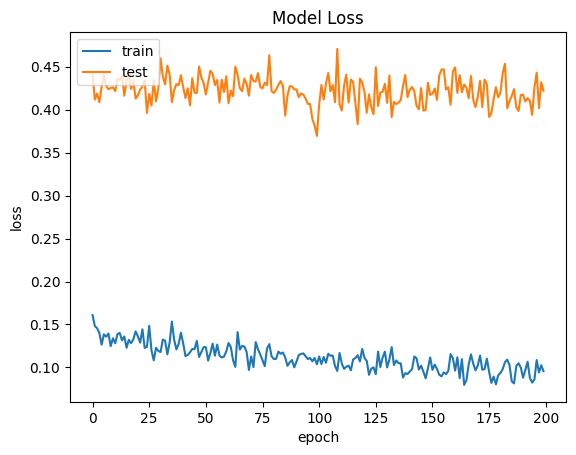

In [ ]:
#Summarize history for loss
plt.title('Model Loss')
plt.plot(Akash.history['loss'])
plt.plot(Akash.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'],loc='upper left')
plt.show()


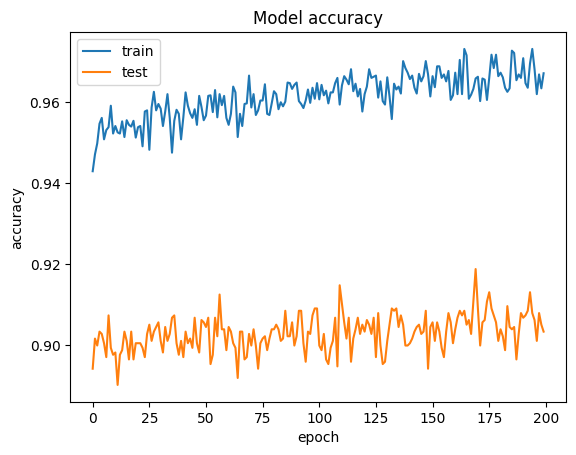

In [ ]:
#Summarize history for accuracy
import matplotlib.pyplot as plt
plt.title('Model accuracy')
plt.plot(Akash.history['accuracy'])
plt.plot(Akash.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'],loc='upper left')
plt.show()

In [ ]:
# !pip install ffmpeg-python

In [ ]:
model.save("model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
filename = '/content/drive/MyDrive/UrbanSound8K/audio/fold3/103199-4-2-6.wav'
audio, sample_rate = librosa.load(filename)
mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate)
new_mfccs_features = np.mean(mfccs_features.T,axis=0)
print(new_mfccs_features)


[ -42.161552    70.2427    -103.71548      9.307578    -7.978771
   -3.9926229  -15.235537     3.666328    -7.252368     4.1459446
  -10.245837    -2.191165    -6.3294673   -2.4772513  -19.111027
    3.360156    -8.386165     2.1535826    1.9040655   -2.3082008]


In [ ]:
new_mfccs_features=new_mfccs_features.reshape(1,-1)
print(new_mfccs_features)
# print(mfccs_scaled_features.shape)
new_mfccs_features = np.expand_dims(new_mfccs_features, axis=0)
predicted_label=model.predict(new_mfccs_features)
predicted_index = np.argmax(predicted_label, axis=-1)
predicted_class = encoder.inverse_transform(predicted_index)

print('Predicted class:', predicted_class)
